# Imports

In [1]:
try:
    from mai_nlp_helper_functions import *
except ImportError as e:
    raise ImportError("You don't have the mai_nlp_helper_functions.py file in the same directory as your notebook. Either add it, or copy paste the contents in this cell") from e


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()


In [3]:
df = pd.read_csv("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_reports.csv")
df["subject"] = df["subject"].fillna("Other")
df

,text,subject
0,"Since its inception in 2010, we have distribut...",Social
1,"I will focus first on traffic, which is a key ...",Other
2,"Also, many farms are aged with degraded soil t...",Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social
4,The company’s U.S. GOM operations can be impac...,Other
...,...,...
2180,American shad are a species of concern for res...,Environmental
2181,Weyerhaeuser's policies address best practices...,Other
2182,compares recently observed trends in weather p...,Environmental
2183,"If our partners, including our licensors, suff...",Other


## Calculate word frequencies

In [4]:
from collections import Counter

documentTokenFrequencies = Counter()

def countWordFrequencies(example):
    tokens = spacy_tokenizer(example)
    documentTokenFrequencies.update(set(tokens)) # change! We only count once now
    # We only count unique tokens per sentence
    
df.progress_apply(countWordFrequencies, axis=1)


  0%|          | 0/2185 [00:00<?, ?it/s]c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2185/2185 [00:32<00:00, 67.17it/s] 


0       None
1       None
2       None
3       None
4       None
        ... 
2180    None
2181    None
2182    None
2183    None
2184    None
Length: 2185, dtype: object

In [5]:
# was 39678
documentTokenFrequencies.total()

35494

In [6]:
len(documentTokenFrequencies.keys())

5529

In [7]:
VOCAB_SIZE = 1000

In [8]:
print("Most frequent")
print(documentTokenFrequencies.most_common(10))
print("Least frequent")
print(documentTokenFrequencies.most_common(VOCAB_SIZE)[-10:])


Most frequent
[('water', 393), ('use', 281), ('include', 261), ('energy', 207), ('company', 188), ('environmental', 184), ('forest', 182), ('product', 173), ('management', 157), ('work', 143)]
Least frequent
[('buyer', 7), ('play', 7), ('basic', 7), ('numerous', 7), ('culture', 7), ('protocol', 7), ('integrate', 7), ('procedure', 7), ('consistent', 7), ('align', 7)]


In [9]:
tokenMap = {k: i+1 for i, (k, _) in enumerate(documentTokenFrequencies.most_common(VOCAB_SIZE-1))}
tokenMap["<oov>"]=0
tokenMapInverse = {v: k for k,v in tokenMap.items()}


## Simple model - TF - IDF

In [10]:
def embed_sentence_TFIDF(example, verbose=False):
    """
    TFIDF
    """
    embedding = np.zeros(VOCAB_SIZE)
    tokens = spacy_tokenizer(example)

    term_frequencies = Counter(tokens)
    if verbose: print(term_frequencies)

    for token in term_frequencies.keys():
        try:
            tokenIndex = tokenMap[token]
        except KeyError: # Out of vocabulary
            tokenIndex = 0

        idf = np.log(len(df) / documentTokenFrequencies[token])
        embedding[tokenIndex] = term_frequencies[token] * idf
        
        if verbose:
            print(f"Token {tokenIndex} '{token}'")
            print(f"  - occurs {term_frequencies[token]} time in sentence = the term frequency")
            print(f"  - occurs in {documentTokenFrequencies[token]} documents = document frequency")
            print(f"  => tf-idf = {embedding[tokenIndex]:.3f}")
            
    if verbose: print(f"Resulting embedding is {embedding}")
    return embedding

sentence = {"text": """The Oat Sustainability Culture initiative will help farmers identify and adopt a culture for improving the efficiency of their entire crop rotation, including oats.”– Denis Trémorin, Director of Sustainability, Pulse Canada Challenges: Sustainability challenges in the wheat supply chain include GHG emission reduction and the need to reduce water usage while increasing biodiversity."""}
print(sentence)
sentence_embedding = embed_sentence_TFIDF(sentence, verbose=True)

print(sentence_embedding)
print(sentence_embedding.shape)
print(sentence)



{'text': 'The Oat Sustainability Culture initiative will help farmers identify and adopt a culture for improving the efficiency of their entire crop rotation, including oats.”– Denis Trémorin, Director of Sustainability, Pulse Canada Challenges: Sustainability challenges in the wheat supply chain include GHG emission reduction and the need to reduce water usage while increasing biodiversity.'}
Counter({'sustainability': 3, 'oat': 2, 'culture': 2, 'include': 2, 'challenge': 2, 'initiative': 1, 'help': 1, 'farmer': 1, 'identify': 1, 'adopt': 1, 'improve': 1, 'efficiency': 1, 'entire': 1, 'crop': 1, 'rotation': 1, '–': 1, 'denis': 1, 'director': 1, 'pulse': 1, 'canada': 1, 'wheat': 1, 'supply': 1, 'chain': 1, 'emission': 1, 'reduction': 1, 'need': 1, 'reduce': 1, 'water': 1, 'usage': 1, 'increase': 1, 'biodiversity': 1})
Token 0 'oat'
  - occurs 2 time in sentence = the term frequency
  - occurs in 1 documents = document frequency
  => tf-idf = 15.379
Token 92 'sustainability'
  - occurs 

In [11]:
df["embedding"] = df.progress_apply(embed_sentence_TFIDF, axis=1)
df

  0%|          | 0/2185 [00:00<?, ?it/s]

100%|██████████| 2185/2185 [00:24<00:00, 87.86it/s]


,text,subject,embedding
0,"Since its inception in 2010, we have distribut...",Social,"[6.3030767464098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,"I will focus first on traffic, which is a key ...",Other,"[6.07993319509559, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,"Also, many farms are aged with degraded soil t...",Environmental,"[6.07993319509559, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social,"[5.897611638301636, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,The company’s U.S. GOM operations can be impac...,Other,"[7.68937110752969, 0.0, 0.0, 0.0, 0.0, 2.45292..."
...,...,...,...
2180,American shad are a species of concern for res...,Environmental,"[7.68937110752969, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2181,Weyerhaeuser's policies address best practices...,Other,"[6.996223926969745, 0.0, 2.0510164381959446, 6..."
2182,compares recently observed trends in weather p...,Environmental,"[6.590758818861581, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2183,"If our partners, including our licensors, suff...",Other,"[7.68937110752969, 0.0, 0.0, 2.124850700206997..."


## Classify

In [12]:
X = np.stack(df["embedding"])
y = np.array(df["subject"])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1638, 1000)
X_test shape: (547, 1000)
y_train shape: (1638,)
y_test shape: (547,)


In [14]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=22141, class_weight="balanced", n_estimators=300)
clf.fit(X_train, y_train)

print("Done")

Done
CPU times: total: 1.25 s
Wall time: 1.47 s


## Evaluate

               precision    recall  f1-score   support

Environmental       0.87      0.64      0.74       299
        Other       0.68      0.62      0.65       115
       Social       0.48      0.80      0.60       133

     accuracy                           0.67       547
    macro avg       0.68      0.69      0.66       547
 weighted avg       0.74      0.67      0.69       547



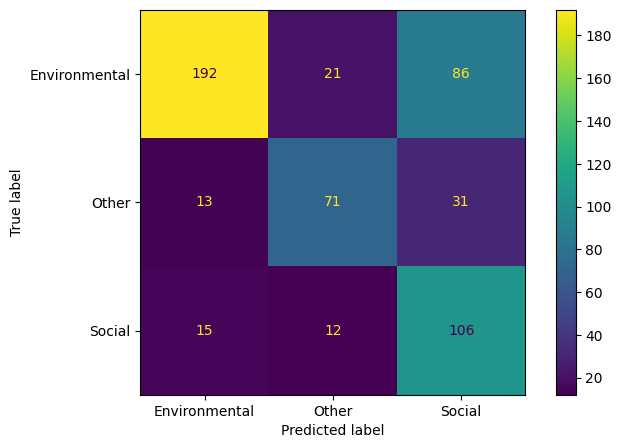

In [16]:

experiment_name = input("Enter experiment name: ")
predictions = clf.predict(X_test)
stats = evaluate_model(y_test, predictions, clf.classes_)
log_experiment_results(experiment_name, stats["macro avg"])